In [1]:
import sys
sys.path.append('..')

In [7]:
import argparse

args_dict = {
    'max_dset_size': 10_000,
    'template_num_task_phrasing': 0,
    'n_shots': 1,
    'max_digit': 10,
}
args = argparse.Namespace(**args_dict)

In [3]:
from data import get_data, TASKS

task_names = TASKS.keys()
task_names

dict_keys(['add_two', 'multiply_two', 'divide_two', 'subtract_two', 'max_two', 'first_two', 'SUFFIXES', 'square_one', 'exp_one', 'prime_one', 'double_one', 'fibonacci_one', 'task1146_country_capital', 'task1147_country_currency', 'task1149_item_check_edible', 'task429_senteval_tense', 'task430_senteval_subject_count', 'task609_sbic_potentially_offense_binary_classification'])

In [8]:
import datasets
import numpy as np
import torch
import transformers
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def test_model_on_task_with_prefix(dset: datasets.Dataset, model: transformers.PreTrainedModel, tokenizer: transformers.PreTrainedTokenizer, prefix: str = '', batch_size: int = 32) -> float:
    """Tests a given language model on a dataset and returns {zero,few}-shot loss. 
    
    Args:
        dset (datasets.Dataset): dataset of examples 
        model (transformers.PreTrainedModel): language model for testing
        tokenizer (transformers.PreTrainedModel): tokenizer to accompany `model`
        prefix (str): Prefix that will be prepended to each example
        batch_size (int): batch size for evaluation
        
    Returns:
        loss (float): language modeling loss on examples in dataset
    """
    np.random.seed(42)
    torch.manual_seed(42)
    
    model.eval()
    model.to(device)
    
    tokenizer.pad_token = tokenizer.eos_token
    
    dataloader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=False, drop_last=False)
    total_loss = 0.0
    
    for idx, batch in enumerate(dataloader):
        x_text = [(prefix + prompt) for prompt in batch['input']]
        print(x_text)
        y_text = [answer for answer in batch['output']] # strip newlines and periods.
        
        x_tokenized = tokenizer(x_text, return_tensors='pt', padding='longest').to(device)
        y_tokenized = tokenizer(y_text, return_tensors='pt', padding='longest').to(device)
        
        true_next_token_ids = y_tokenized['input_ids'][:, 0] # only test on the single next token
        
        with torch.no_grad():
            all_token_logits = model(**x_tokenized)['logits']
            pred_next_token_logits = all_token_logits[:, -1, :]
            loss = torch.nn.functional.cross_entropy(input=pred_next_token_logits, target=true_next_token_ids)
        total_loss += loss.item()
    
    return total_loss
                    

In [5]:
model_name = 'gpt2-medium'

model = transformers.AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=False)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, output_hidden_states=False)

In [9]:
dset, check_answer_func, description = get_data(args=args, task_name='fibonacci_one')
test_model_on_task_with_prefix(dset=dset, model=model, tokenizer=tokenizer, prefix=f'asldjfo the following numbers. ')

10 max_digit 10 dset_size 10000 10
<class 'str'>
['asldjfo the following numbers. Given the input x is 0, the output f(x) is', 'asldjfo the following numbers. Given the input x is 0, the output f(x) is', 'asldjfo the following numbers. Given the input x is 0, the output f(x) is', 'asldjfo the following numbers. Given the input x is 0, the output f(x) is', 'asldjfo the following numbers. Given the input x is 0, the output f(x) is', 'asldjfo the following numbers. Given the input x is 0, the output f(x) is', 'asldjfo the following numbers. Given the input x is 0, the output f(x) is', 'asldjfo the following numbers. Given the input x is 0, the output f(x) is', 'asldjfo the following numbers. Given the input x is 0, the output f(x) is', 'asldjfo the following numbers. Given the input x is 0, the output f(x) is']


1.8290717601776123

In [10]:
task_information = {}
task_descriptions = []
task_names = ['add_two', 'divide_two', 'square_one', 'fibonacci_one']
# task_names = ['add_two', 'multiply_two', 'divide_two', 'subtract_two', 'max_two', 'first_two', 'SUFFIXES', 'square_one', 'exp_one', 'prime_one', 'double_one', 'fibonacci_one']

for name in task_names:
    dset, check_answer_func, description = get_data(args=args, task_name=name)
    task_descriptions.append(description)
    
task_descriptions

100 max_digit 10 dset_size 10000 100
<class 'str'>
100 max_digit 10 dset_size 10000 100
<class 'str'>
10 max_digit 10 dset_size 10000 10
<class 'str'>
10 max_digit 10 dset_size 10000 10
<class 'str'>


['Return the sum of the inputs.',
 'Return the quotient of the inputs.',
 'Square the input to get the output.',
 'Given an input x, return the xth fibonacci number.']

In [11]:
losses = np.zeros((len(task_names), len(task_descriptions)))

In [12]:
# TODO incorporate check_answer_func... And use huggingface decoding for that.

for i in range(len(task_names)):
    name = task_names[i]
    for j in range(len(task_descriptions)):
        description = task_descriptions[j]
        #
        dset, check_answer_func, __this_task_description = get_data(args=args, task_name=name)
        losses[i][j] += test_model_on_task_with_prefix(dset=dset, model=model, tokenizer=tokenizer, prefix=f'{description} ')

100 max_digit 10 dset_size 10000 100
<class 'str'>
['Return the sum of the inputs. Given the input numbers 1 and 4, the answer is', 'Return the sum of the inputs. Given the input numbers 8 and 3, the answer is', 'Return the sum of the inputs. Given the input numbers 5 and 2, the answer is', 'Return the sum of the inputs. Given the input numbers 7 and 1, the answer is', 'Return the sum of the inputs. Given the input numbers 6 and 0, the answer is', 'Return the sum of the inputs. Given the input numbers 0 and 9, the answer is', 'Return the sum of the inputs. Given the input numbers 5 and 3, the answer is', 'Return the sum of the inputs. Given the input numbers 2 and 7, the answer is', 'Return the sum of the inputs. Given the input numbers 1 and 2, the answer is', 'Return the sum of the inputs. Given the input numbers 3 and 3, the answer is', 'Return the sum of the inputs. Given the input numbers 0 and 5, the answer is', 'Return the sum of the inputs. Given the input numbers 1 and 6, the 

<AxesSubplot:>

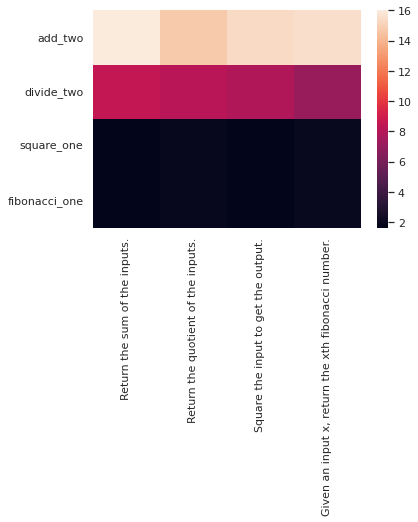

In [17]:
import seaborn as sns
sns.set()

sns.heatmap(torch.tensor(losses), yticklabels=task_names, xticklabels=task_descriptions)